<a href="https://colab.research.google.com/github/Stalinosmj/R_project-/blob/main/India_climate_change(R).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
knitr::opts_chunk$set(echo = TRUE)

In [2]:
install.packages("remotes")
remotes::install_github("inSileco/rchelsa")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)





── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp84QTEp/remotes63b248d48a3/inSileco-rchelsa-e01a2b8/DESCRIPTION’ ... OK
* preparing ‘rchelsa’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘rchelsa_0.0.0.9001.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
install.packages("pacman")
install.packages("rnaturalearthdata")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘terra’



geodata installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’



sf installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


biscale installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘globals’, ‘listenv’, ‘parallelly’, ‘png’, ‘sp’, ‘progressr’, ‘future’, ‘furrr’, ‘slippymath’, ‘raster’



elevatr installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


cowplot installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


gridGraphics installed

Installing package into ‘/usr/loca

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[1] "CHELSA_bio10_01.tif" "CHELSA_bio10_12.tif" "sample_data"

Mosaicing & Projecting

Clipping DEM to locations

Note: Elevation units are in meters.



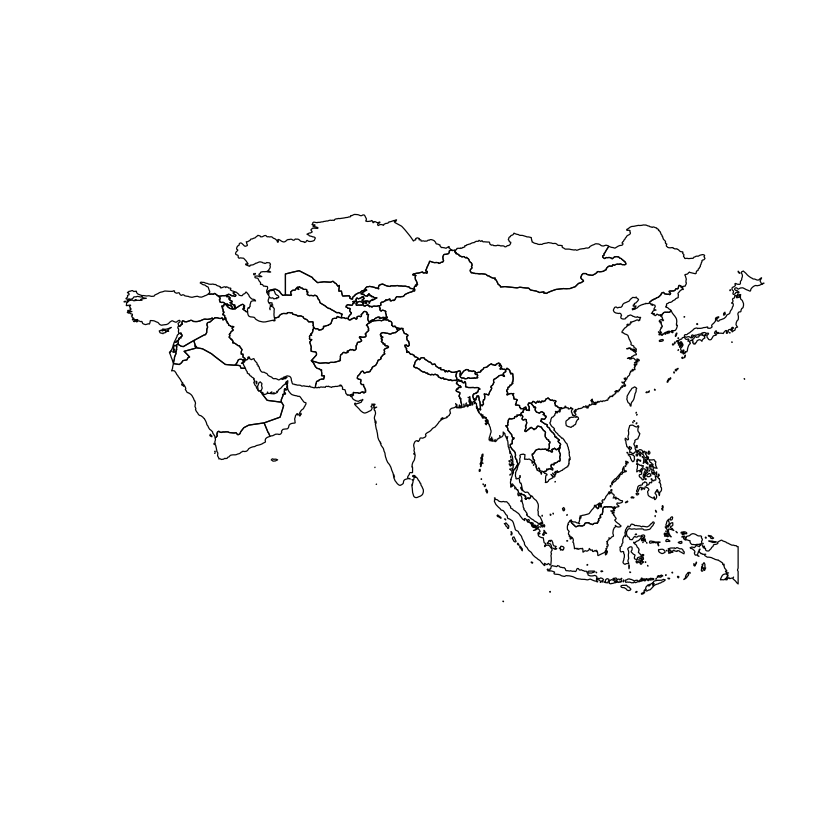

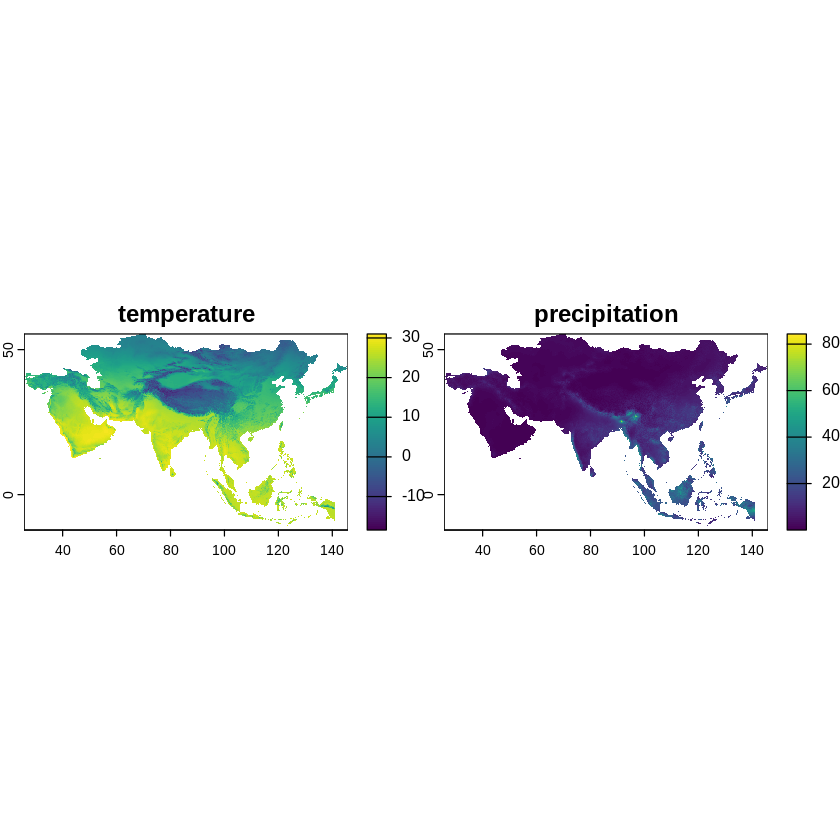

In [4]:
# 1. SETUP
# --------

# Install and load necessary packages
install.packages("pacman")
pacman::p_load(
  geodata, tidyverse, sf, terra,
  rchelsa, biscale, elevatr, cowplot,
  gridGraphics, rayshader, rnaturalearth
)

# 2. CHELSA DATA
# ----------------

# set the working directory
main_dir <- getwd()

# define a vector of IDs to download
ids <- c(1, 12)

# function to download CHELSA data
download_chelsa_data <- function(id, path){
  rchelsa::get_chelsea_data(
    categ = "clim", type = "bio",
    id = id, path = path
  )
}

# download data for each id
lapply(ids, download_chelsa_data, path = main_dir)
list.files()

# load the raster files
temp <- terra::rast("/content/CHELSA_bio10_01.tif")
prec <- terra::rast("/content/CHELSA_bio10_12.tif")

# average precipitation (convert to monthly average)
prec_average <- prec / 12 # Changed from 30 to 12 for monthly average
temp_celsius <- temp / 10

# Combine average temperature and precipitation
# into a raster stack
temp_prec <- c(temp_celsius, prec_average)

# assign names to each layer in the stack
names(temp_prec) <- c("temperature", "precipitation")
asia_sf <- rnaturalearth::ne_countries(
  continent = "Asia",
  returnclass = "sf",
  scale = "medium" # Use "large" for more detail, "small" for faster processing
)

# Plot to check
plot(st_geometry(asia_sf))
# define the target CRS
target_crs <- "EPSG:4326"

# crop the input raster to the
# country's extent and apply a mask
temp_prec_country <- terra::crop(
  temp_prec, asia_sf,
  mask = TRUE
)

# Obtain AWS tiles DEM data from elevatr
# convert to terra SpatRaster and crop
dem <- elevatr::get_elev_raster(
  locations = asia_sf, z = 5,
  clip = "locations"
) |> terra::rast() |>
  terra::crop(asia_sf, mask = TRUE)

# resample the raster to match DEM resolution
# using bilinear interpolation, then reproject
temp_prec_resampled <- terra::resample(
  x = temp_prec_country,
  y = dem, method = "bilinear"
) |> terra::project(target_crs)

# plot the resampled raster
terra::plot(temp_prec_resampled)

Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”


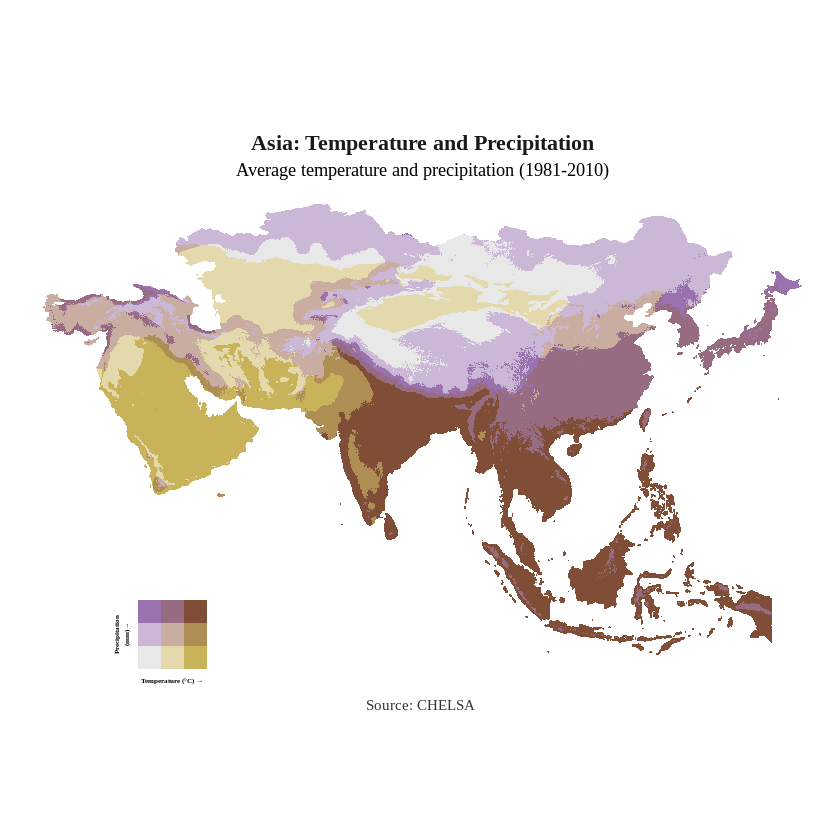

In [5]:
# Apply smoothing to reduce noise and create more coherent patterns
# Convert back to raster for smoothing
temp_smooth <- terra::focal(temp_prec_resampled[["temperature"]],
                           w = matrix(1, 7, 7), fun = "mean", na.rm = TRUE)
prec_smooth <- terra::focal(temp_prec_resampled[["precipitation"]],
                           w = matrix(1, 7, 7), fun = "mean", na.rm = TRUE)

# Combine smoothed layers
temp_prec_smooth <- c(temp_smooth, prec_smooth)
names(temp_prec_smooth) <- c("temperature", "precipitation")

# Convert smoothed raster to dataframe
temp_prec_df <- as.data.frame(
  temp_prec_smooth, xy = TRUE
)

# Remove NA values for better classification
temp_prec_df <- temp_prec_df[complete.cases(temp_prec_df), ]

# Create bivariate classes using biscale - FIXED: temperature on x, precipitation on y
breaks <- biscale::bi_class(
  temp_prec_df, x = temperature, # Changed: temperature on x-axis
  y = precipitation, style = "quantile", # Changed: precipitation on y-axis
  dim = 3
)

# Define the color palette
pal <- "Brown"

# Define a custom theme for the map with different font
theme_for_the_win <- function(){
  theme_minimal() +
    theme(
      axis.title = element_blank(),
      axis.text = element_blank(),
      axis.ticks = element_blank(),
      panel.grid = element_blank(),
      plot.background = element_rect(
        fill = "white", color = NA
      ),
      plot.title = element_text(
        color = "grey10", hjust = .5,
        face = "bold", vjust = -1,
        family = "serif" # Changed font to serif
      ),
      plot.subtitle = element_text(
        hjust = .5, vjust = -1,
        family = "serif" # Changed font to serif
      ),
      plot.caption = element_text(
        size = 9, color = "grey20",
        hjust = .5, vjust = 1,
        family = "serif" # Changed font to serif
      ),
      plot.margin = unit(c(0, 0, 0, 0), "lines"),
      legend.position = "none", # Ensure no legend
      text = element_text(family = "serif") # Set overall font family
    )
}

# 6. 2D BIVARIATE MAP
# --------------------

# Create the bivariate map using ggplot2
map <- ggplot(breaks) +
  geom_raster(
    aes(
      x = x, y = y, fill = bi_class
    ), show.legend = FALSE # Changed to FALSE to remove legend
  ) +
  biscale::bi_scale_fill(
    pal = pal, dim = 3,
    flip_axes = FALSE, # Changed: no need to flip since we fixed the axes
    rotate_pal = FALSE
  ) +
  labs(
    title = "Asia: Temperature and Precipitation",
    subtitle = "Average temperature and precipitation (1981-2010)",
    caption = "Source: CHELSA ",
    x = "", y = ""
  ) +
  coord_sf(crs = target_crs) +
  theme_for_the_win()

# Create legend with dummy labels first, then remove them
legend_base <- biscale::bi_legend(
  pal = pal,
  flip_axes = FALSE,
  rotate_pal = FALSE,
  dim = 3,
  xlab = "X", # Dummy label
  ylab = "Y", # Dummy label
  size = 6
) +
  theme_void() +
  theme(
    axis.title = element_blank(), # Remove the dummy labels
    axis.text = element_blank()
  )

# Create custom text elements with proper positioning
temp_label <- ggplot() +
  annotate("text", x = 0.5, y = 0.5, label = "Temperature (°C) →",
           size = 1.5, fontface = "bold", family = "serif", color = "black") +
  theme_void() +
  theme(plot.margin = margin(0, 0, 0, 0))

prec_label <- ggplot() +
  annotate("text", x = 0.5, y = 0.5, label = "Precipitation\n(mm)→",
           size = 1.5, fontface = "bold", family = "serif", color = "black",
           angle = 90, hjust = 0.5, vjust = 0.5) +
  theme_void() +
  theme(plot.margin = margin(0, 0, 0, 0))

# Combine into a complete legend
legend <- cowplot::ggdraw() +
  # Main legend square
  cowplot::draw_plot(legend_base, x = 0.2, y = 0.2, width = 0.6, height = 0.6) +
  # Temperature label below
  cowplot::draw_plot(temp_label, x = 0.2, y = 0.05, width = 0.6, height = 0.15) +
  # Precipitation label on left
  cowplot::draw_plot(prec_label, x = 0.0, y = 0.2, width = 0.2, height = 0.6)

# Combine the map and legend using cowplot
full_map <- cowplot::ggdraw() +
  cowplot::draw_plot(
    plot = map, x = 0, y = 0,
    width = 1, height = 1
  ) +
  cowplot::draw_plot(
    plot = legend, x = .13, y = 0.17,
    width = .15, height = .15
  )

# Display the final map with legend
print(full_map)

# Save as PNG file
ggsave(
  filename = "asia_bivariate_2d.png",
  width = 7, height = 7, dpi = 600,
  device = "png", bg = "white", full_map
)

In [6]:
# 7. CREATE TERRAIN LAYER
# ------------------------

# project and convert to DEM to dataframe
dem_df <- dem |>
  terra::project(target_crs) |>
  as.data.frame(xy = TRUE, na.rm = TRUE)

# rename the third column to "dem"
names(dem_df)[3] <- "dem"

# create the terrain layer map
dem_map <- ggplot(
  dem_df, aes(x = x, y = y, fill = dem)
) +
  geom_raster() +
  scale_fill_gradientn(colors = "white") +
  guides(fill = "none") +
  labs(
    title = "Asia: Temperature and Precipitation",
    subtitle = "Average temperature and precipitation (1981-2010)",
    caption = "Source: CHELSA "
  ) +
  coord_sf(crs = target_crs) +
  theme_for_the_win() +
  theme(legend.position = "none")

# 8. RENDER 3D SCENE
# -------------------

rayshader::plot_gg(
  ggobj = full_map, # Use map without legend
  ggobj_height = dem_map,
  width = 7,
  height = 7,
  windowsize = c(600, 600),
  scale = 100,
  shadow = TRUE,
  shadow_intensity = 1,
  phi = 87, theta = 0, zoom = .56,
  multicore = TRUE
)

# zoom out
rayshader::render_camera(zoom = .6)

# 9. LIGHTS
# ----------

url <- "https://dl.polyhaven.org/file/ph-assets/HDRIs/hdr/4k/brown_photostudio_02_4k.hdr"
hdri_file <- basename(url)
download.file(
  url = url,
  destfile = hdri_file,
  mode = "wb"
)

# 10. RENDER 3D OBJECT
# ---------------------

rayshader::render_highquality(
  filename = "asia-bivariate-3d.png",
  preview = TRUE,
  light = FALSE,
  environment_light = hdri_file,
  intensity = 1.2,
  rotate_env = 90,
  parallel = TRUE,
  width = 2000, height = 2000,
  interactive = FALSE
)

Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’



forecast installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’



caret installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


randomForest installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Deriv’



neuralnet installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘config’, ‘tfautograph’, ‘reticulate’, 

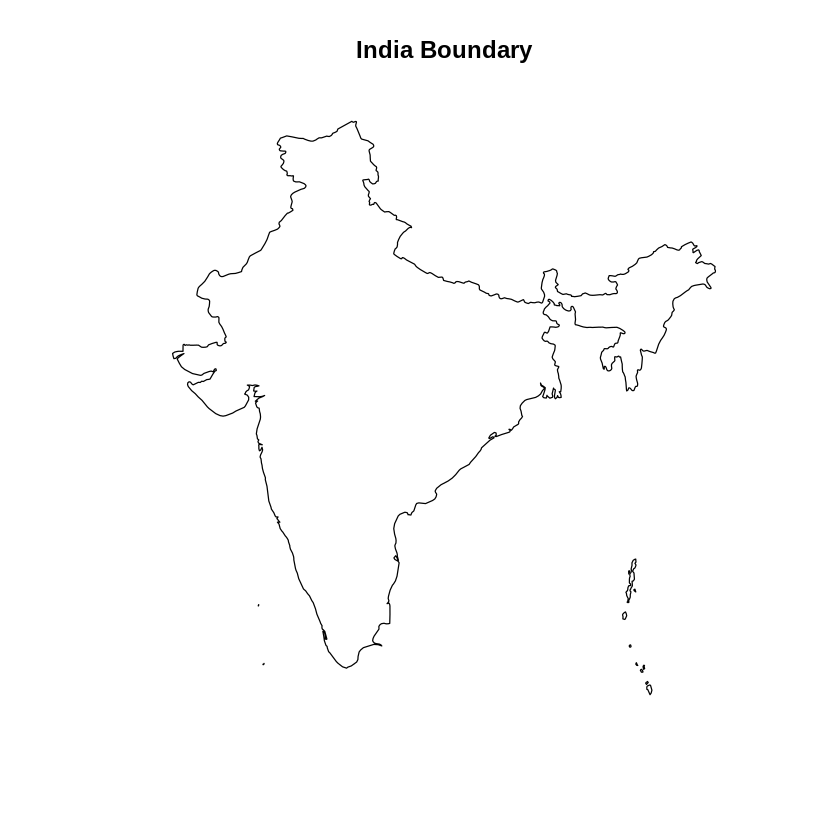

In [7]:
# 11. INDIA-SPECIFIC ANALYSIS
# ============================

# Load additional packages for prediction models
pacman::p_load(
  forecast, tseries, caret, randomForest,
  neuralnet, keras, tensorflow, lubridate,
  dplyr, ggplot2, plotly, corrplot
)

# Extract India from Asia boundaries
india_sf <- asia_sf[asia_sf$sovereignt == "India",]

# Plot India boundary to verify
plot(st_geometry(india_sf), main = "India Boundary")

# Crop climate data specifically for India
temp_prec_india <- terra::crop(
  temp_prec, india_sf,
  mask = TRUE
)

# Get DEM data for India
dem_india <- elevatr::get_elev_raster(
  locations = india_sf, z = 6,
  clip = "locations"
) |> terra::rast() |>
  terra::crop(india_sf, mask = TRUE)

# Resample to match DEM resolution
temp_prec_india_resampled <- terra::resample(
  x = temp_prec_india,
  y = dem_india, method = "bilinear"
) |> terra::project(target_crs)

# Apply smoothing for India
temp_india_smooth <- terra::focal(temp_prec_india_resampled[["temperature"]],
                                 w = matrix(1, 5, 5), fun = "mean", na.rm = TRUE)
prec_india_smooth <- terra::focal(temp_prec_india_resampled[["precipitation"]],
                                 w = matrix(1, 5, 5), fun = "mean", na.rm = TRUE)

# Combine smoothed India layers
temp_prec_india_smooth <- c(temp_india_smooth, prec_india_smooth)
names(temp_prec_india_smooth) <- c("temperature", "precipitation")

Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”


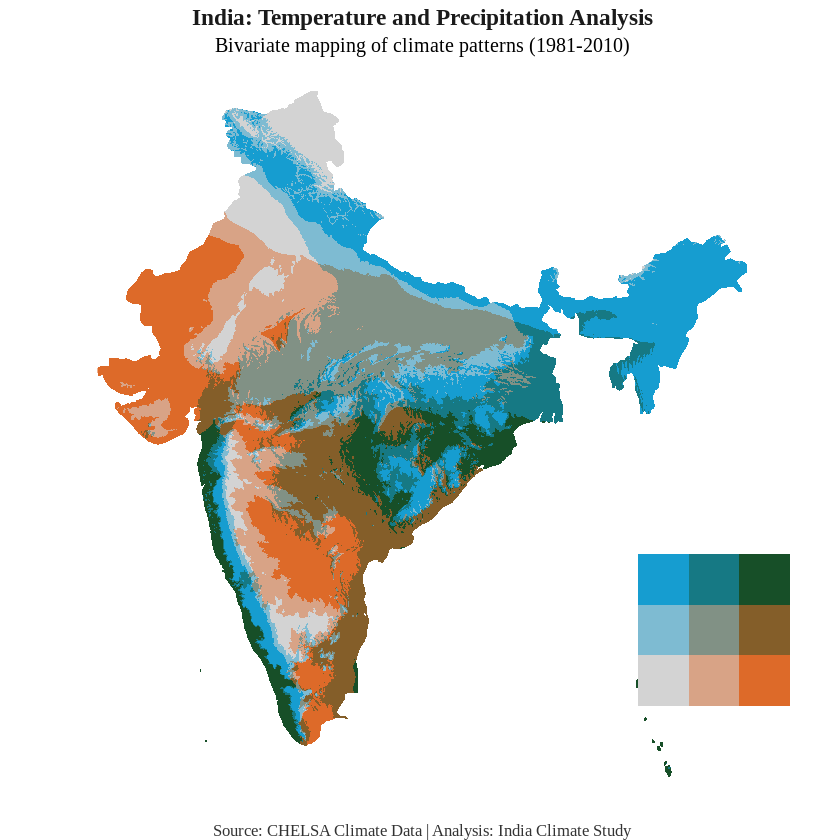

In [8]:
# 12. INDIA BIVARIATE VISUALIZATION
# ==================================

# Convert India raster to dataframe
temp_prec_india_df <- as.data.frame(
  temp_prec_india_smooth, xy = TRUE
)

# Remove NA values
temp_prec_india_df <- temp_prec_india_df[complete.cases(temp_prec_india_df), ]

# Create bivariate classes for India
india_breaks <- biscale::bi_class(
  temp_prec_india_df,
  x = temperature,
  y = precipitation,
  style = "quantile",
  dim = 3
)

# India-specific color palette
india_pal <- "BlueOr"


# Custom theme for India maps
theme_india <- function(){
  theme_minimal() +
    theme(
      axis.title = element_blank(),
      axis.text = element_blank(),
      axis.ticks = element_blank(),
      panel.grid = element_blank(),
      plot.background = element_rect(fill = "white", color = NA),
      plot.title = element_text(
        color = "grey10", hjust = .5, face = "bold",
        vjust = -1, family = "serif", size = 14
      ),
      plot.subtitle = element_text(
        hjust = .5, vjust = -1, family = "serif", size = 12
      ),
      plot.caption = element_text(
        size = 10, color = "grey20", hjust = .5,
        vjust = 1, family = "serif"
      ),
      plot.margin = unit(c(0, 0, 0, 0), "lines"),
      legend.position = "none"
    )
}

# Create India bivariate map
india_map <- ggplot(india_breaks) +
  geom_raster(aes(x = x, y = y, fill = bi_class), show.legend = FALSE) +
  biscale::bi_scale_fill(pal = india_pal, dim = 3,
                        flip_axes = FALSE, rotate_pal = FALSE) +
  labs(
    title = "India: Temperature and Precipitation Analysis",
    subtitle = "Bivariate mapping of climate patterns (1981-2010)",
    caption = "Source: CHELSA Climate Data | Analysis: India Climate Study"
  ) +
  coord_sf(crs = target_crs) +
  theme_india()

# Create legend for India
india_legend_base <- biscale::bi_legend(
  pal = india_pal, flip_axes = FALSE, rotate_pal = FALSE,
  dim = 3, xlab = "Temperature", ylab = "Precipitation", size = 8
) + theme_void()

# Combine India map and legend
india_full_map <- cowplot::ggdraw() +
  cowplot::draw_plot(india_map, x = 0, y = 0, width = 1, height = 1) +
  cowplot::draw_plot(india_legend_base, x = 0.75, y = 0.15, width = 0.2, height = 0.2)

# Display India map
print(india_full_map)

# Save India map
ggsave("india_climate_bivariate.png", india_full_map,
       width = 10, height = 8, dpi = 600, bg = "white")

[1] "India Climate Zone Statistics:"
# A tibble: 7 × 6
  climate_zone      avg_temp avg_precip area_coverage temp_range precip_range
  <chr>                <dbl>      <dbl>         <int> <chr>      <chr>       
1 Tropical Dry         26.8        50.4        802915 25 - 29    9.2 - 75    
2 Tropical Moderate    26.4       100.         744344 25 - 28.9  75 - 150    
3 Subtropical Wet      22.8       174.         437539 15 - 25    100 - 892.8 
4 Subtropical Dry      24.2        67.5        261295 15 - 25    23.2 - 100  
5 Temperate             1.66      106.         195397 -14.9 - 15 4.1 - 620.7 
6 Tropical Wet         26.6       255.          93209 25 - 27.8  150 - 711.4 
7 Other                25          98.5         12218 25 - 25    23 - 258.5  


Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”


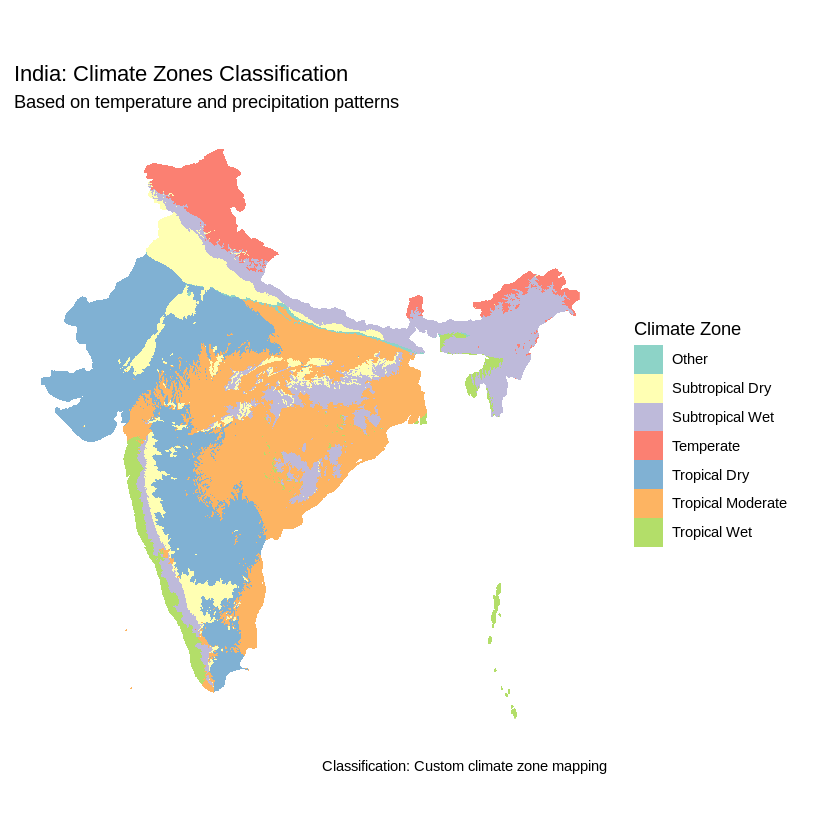

In [9]:
# 13. INDIA CLIMATE ZONES ANALYSIS
# =================================

# Extract climate data for major Indian regions
india_climate_stats <- temp_prec_india_df %>%
  mutate(
    climate_zone = case_when(
      temperature > 25 & precipitation > 150 ~ "Tropical Wet",
      temperature > 25 & precipitation < 150 & precipitation > 75 ~ "Tropical Moderate",
      temperature > 25 & precipitation < 75 ~ "Tropical Dry",
      temperature < 25 & temperature > 15 & precipitation > 100 ~ "Subtropical Wet",
      temperature < 25 & temperature > 15 & precipitation < 100 ~ "Subtropical Dry",
      temperature < 15 ~ "Temperate",
      TRUE ~ "Other"
    )
  )

# Calculate statistics by climate zone
climate_summary <- india_climate_stats %>%
  group_by(climate_zone) %>%
  summarise(
    avg_temp = round(mean(temperature, na.rm = TRUE), 2),
    avg_precip = round(mean(precipitation, na.rm = TRUE), 2),
    area_coverage = n(),
    temp_range = paste0(round(min(temperature, na.rm = TRUE), 1),
                       " - ", round(max(temperature, na.rm = TRUE), 1)),
    precip_range = paste0(round(min(precipitation, na.rm = TRUE), 1),
                         " - ", round(max(precipitation, na.rm = TRUE), 1))
  ) %>%
  arrange(desc(area_coverage))

print("India Climate Zone Statistics:")
print(climate_summary)

# Create climate zones map
climate_zones_map <- ggplot(india_climate_stats) +
  geom_raster(aes(x = x, y = y, fill = climate_zone)) +
  scale_fill_brewer(type = "qual", palette = "Set3", name = "Climate Zone") +
  labs(
    title = "India: Climate Zones Classification",
    subtitle = "Based on temperature and precipitation patterns",
    caption = "Classification: Custom climate zone mapping"
  ) +
  coord_sf(crs = target_crs) +
  theme_minimal() +
  theme(
    axis.title = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    legend.position = "right"
  )

print(climate_zones_map)
ggsave("india_climate_zones.png", climate_zones_map,
       width = 12, height = 8, dpi = 600, bg = "white")

[1] "India Climate Time Series Data (first 10 rows):"


,Year,Month,Date,temperature,precipitation,humidity,wind_speed,pressure
,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2000,1,2000-01-01,25.01473,63.24317,53.35613,11.836715,1011.796
2,2000,2,2000-02-01,26.27796,33.21658,57.64433,16.553026,1010.488
3,2000,3,2000-03-01,27.57433,37.50051,61.98449,13.603874,1010.700
4,2000,4,2000-04-01,26.42830,46.49938,72.55220,17.131055,1010.461
5,2000,5,2000-05-01,25.35962,77.12702,77.35755,14.936867,1011.334
6,2000,6,2000-06-01,24.65250,108.58891,79.79531,15.665991,1013.139
7,2000,7,2000-07-01,22.52543,169.92283,75.62726,10.860799,1013.907
8,2000,8,2000-08-01,20.56437,170.16797,73.49732,10.143623,1015.180
9,2000,9,2000-09-01,20.45155,207.86282,62.92209,7.436347,1016.255


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


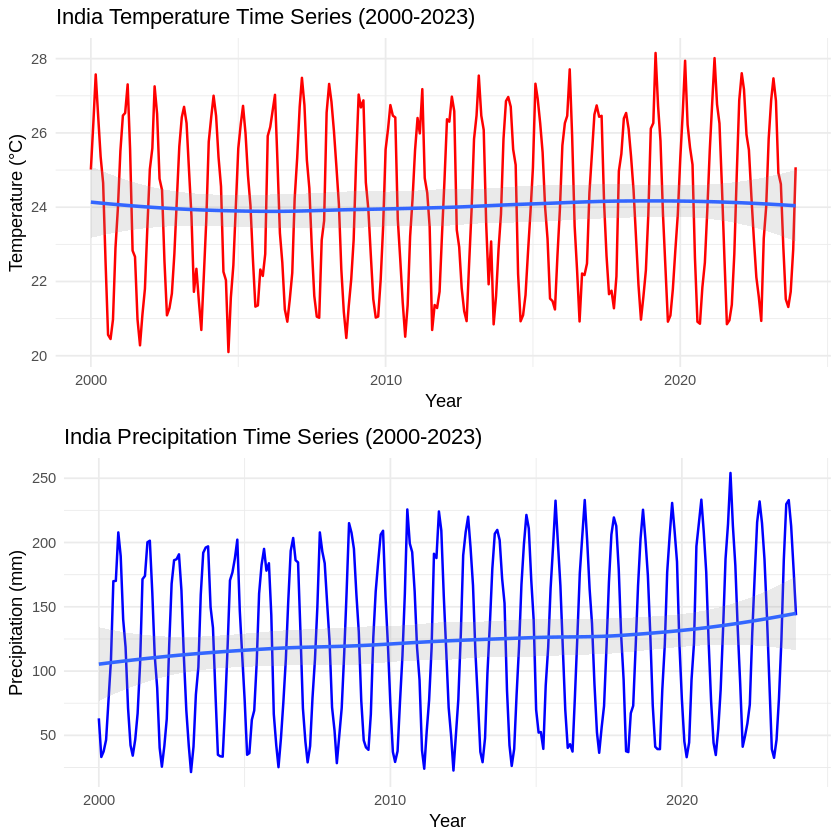

In [10]:
# 14. TIME SERIES DATA PREPARATION FOR PREDICTION MODELS
# =======================================================

# Create synthetic time series data based on spatial climate patterns
# (In real scenario, you would load actual historical time series data)

# Generate synthetic monthly data for demonstration
set.seed(123)
years <- 2000:2023
months <- 1:12
dates <- expand.grid(Year = years, Month = months) %>%
  mutate(Date = as.Date(paste(Year, Month, "01", sep = "-"))) %>%
  arrange(Date)

# Calculate mean climate values for India
mean_temp_india <- mean(temp_prec_india_df$temperature, na.rm = TRUE)
mean_precip_india <- mean(temp_prec_india_df$precipitation, na.rm = TRUE)

# Generate realistic time series with seasonal patterns
india_time_series <- dates %>%
  mutate(
    # Temperature with seasonal variation and trend
    temperature = mean_temp_india +
      3 * sin(2 * pi * Month / 12) +  # Seasonal variation
      0.02 * (Year - 2000) +          # Warming trend
      rnorm(n(), 0, 0.5),             # Random noise

    # Precipitation with monsoon patterns
    precipitation = mean_precip_india *
      (1 + 0.8 * sin(2 * pi * (Month - 6) / 12)) * # Monsoon peak around July
      (1 + 0.01 * (Year - 2000)) +                 # Slight trend
      abs(rnorm(n(), 0, mean_precip_india * 0.15)), # Random variation

    # Add other meteorological variables
    humidity = 65 + 15 * sin(2 * pi * (Month - 3) / 12) + rnorm(n(), 0, 2),
    wind_speed = 12 + 4 * sin(2 * pi * (Month - 1) / 12) + rnorm(n(), 0, 1),
    pressure = 1013 + 3 * sin(2 * pi * (Month - 6) / 12) + rnorm(n(), 0, 0.5)
  )

# Display first few rows
print("India Climate Time Series Data (first 10 rows):")
head(india_time_series, 10)

# Create time series plots
temp_plot <- ggplot(india_time_series, aes(x = Date, y = temperature)) +
  geom_line(color = "red", size = 0.7) +
  geom_smooth(method = "loess", se = TRUE, alpha = 0.2) +
  labs(title = "India Temperature Time Series (2000-2023)",
       x = "Year", y = "Temperature (°C)") +
  theme_minimal()

precip_plot <- ggplot(india_time_series, aes(x = Date, y = precipitation)) +
  geom_line(color = "blue", size = 0.7) +
  geom_smooth(method = "loess", se = TRUE, alpha = 0.2) +
  labs(title = "India Precipitation Time Series (2000-2023)",
       x = "Year", y = "Precipitation (mm)") +
  theme_minimal()

# Combine plots
combined_plot <- cowplot::plot_grid(temp_plot, precip_plot, ncol = 1)
print(combined_plot)

# Save time series data
write.csv(india_time_series, "india_climate_timeseries.csv", row.names = FALSE)

Warning message in adf.test(temp_ts):
“p-value smaller than printed p-value”
Warning message in adf.test(precip_ts):
“p-value smaller than printed p-value”


[1] "Temperature ADF p-value: 0.01"
[1] "Precipitation ADF p-value: 0.01"
[1] "Temperature ARIMA Model:"
Series: temp_ts 
ARIMA(1,0,1)(0,1,1)[12] 

Coefficients:
          ar1     ma1     sma1
      -0.8396  0.9283  -0.8476
s.e.   0.0726  0.0506   0.0425

sigma^2 = 0.2568:  log likelihood = -210.51
AIC=429.02   AICc=429.17   BIC=443.5

Training set error measures:
                     ME      RMSE       MAE       MPE     MAPE      MASE
Training set 0.08070569 0.4933845 0.3792451 0.3059885 1.579906 0.6788612
                    ACF1
Training set -0.06273078
[1] "Precipitation ARIMA Model:"
Series: precip_ts 
ARIMA(0,0,0)(0,1,2)[12] with drift 

Coefficients:
         sma1     sma2   drift
      -0.6972  -0.1160  0.0741
s.e.   0.0664   0.0659  0.0115

sigma^2 = 89.11:  log likelihood = -1015.72
AIC=2039.44   AICc=2039.58   BIC=2053.92

Training set error measures:
                      ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.07306313 9.190603 7.218306 -2.483952 

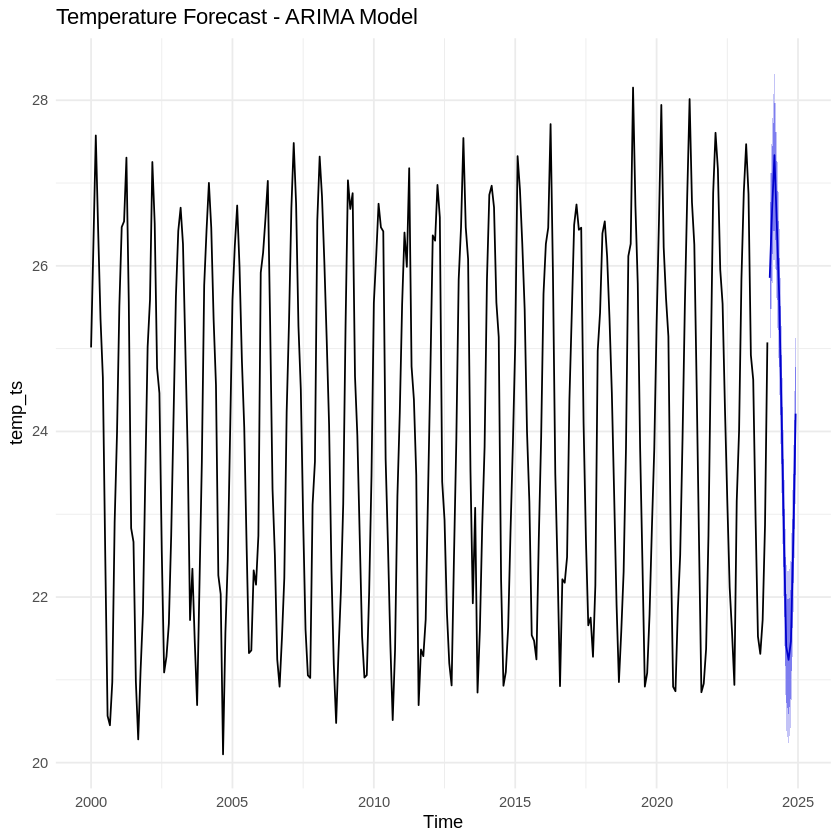

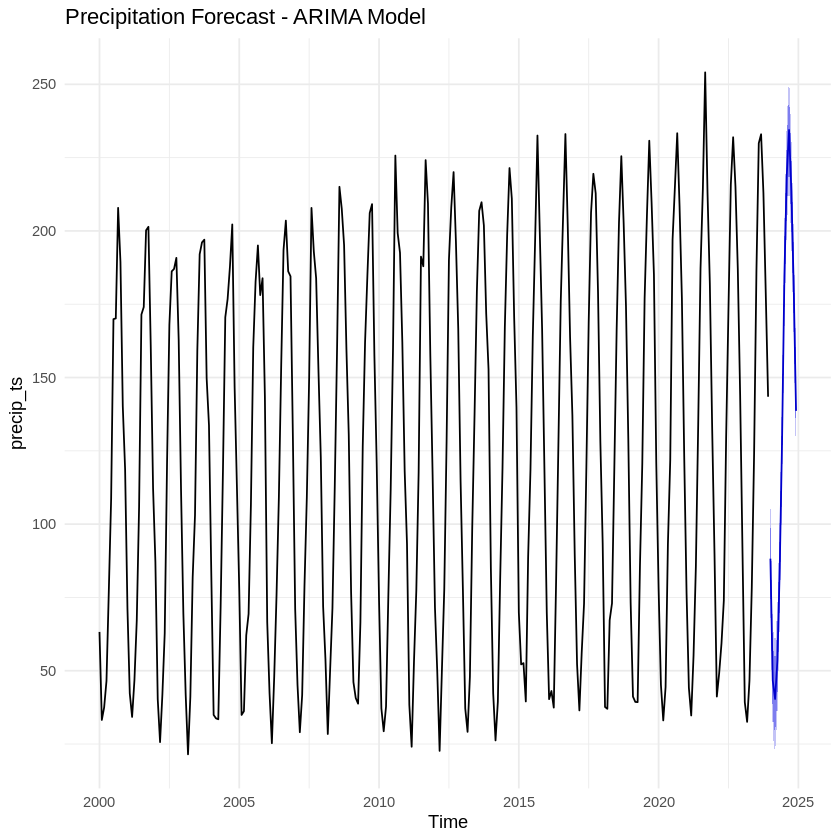


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1)(0,1,1)[12]
Q* = 20.517, df = 21, p-value = 0.4887

Model df: 3.   Total lags used: 24



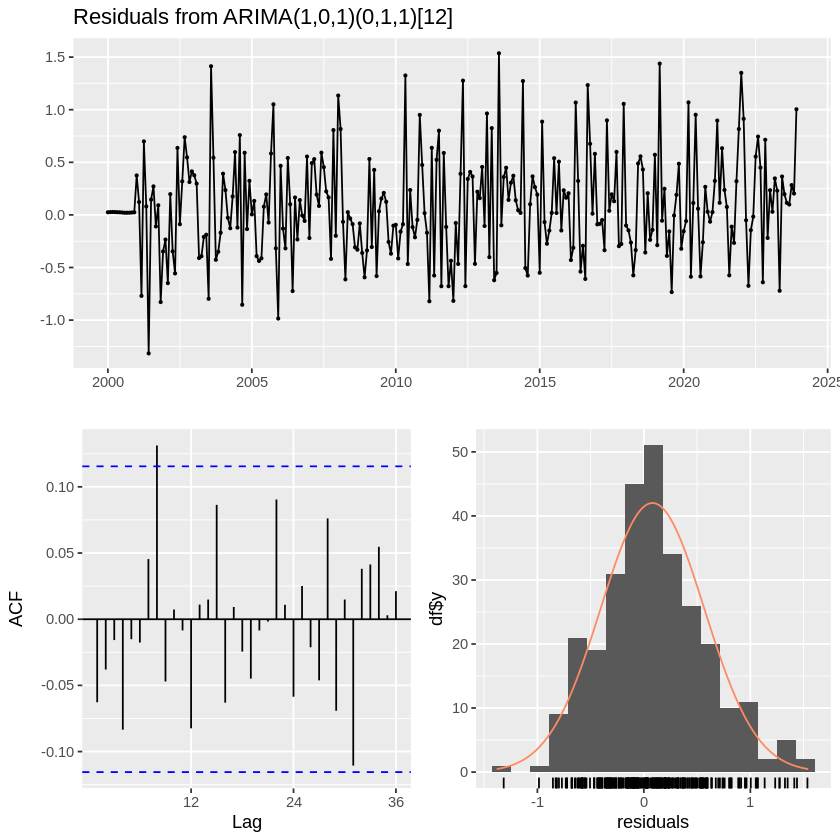


	Ljung-Box test

data:  Residuals from ARIMA(0,0,0)(0,1,2)[12] with drift
Q* = 24.482, df = 22, p-value = 0.3225

Model df: 2.   Total lags used: 24



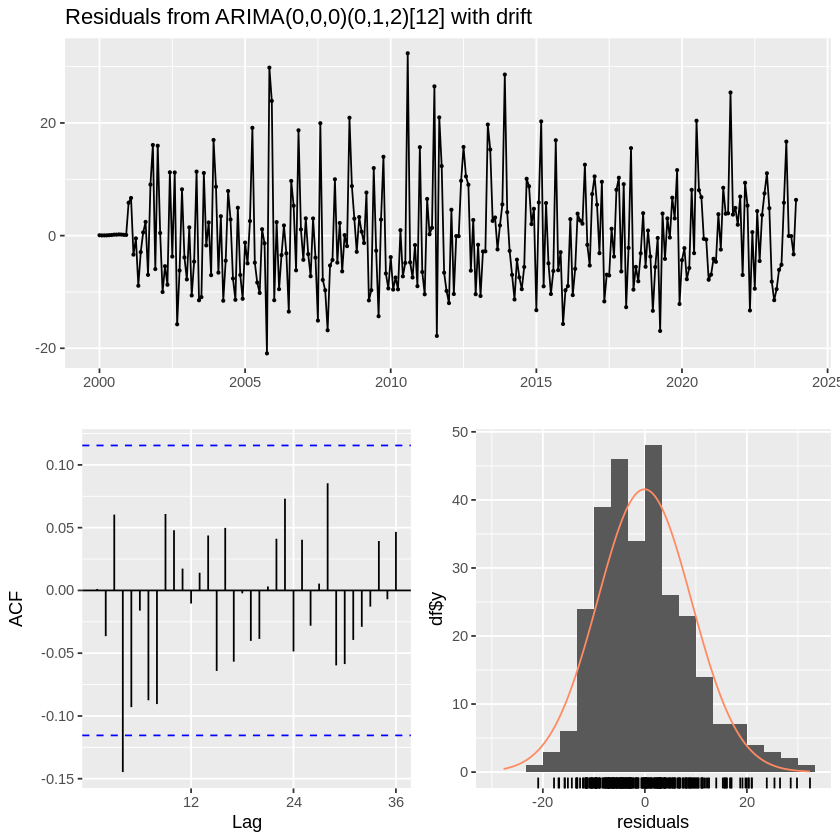

In [11]:
# 15. ARIMA PREDICTION MODEL
# ===========================

# Convert to time series objects
temp_ts <- ts(india_time_series$temperature,
              start = c(2000, 1), frequency = 12)
precip_ts <- ts(india_time_series$precipitation,
                start = c(2000, 1), frequency = 12)

# Check stationarity
adf_temp <- adf.test(temp_ts)
adf_precip <- adf.test(precip_ts)

print(paste("Temperature ADF p-value:", round(adf_temp$p.value, 4)))
print(paste("Precipitation ADF p-value:", round(adf_precip$p.value, 4)))

# Fit ARIMA models
arima_temp <- auto.arima(temp_ts, seasonal = TRUE,
                        stepwise = FALSE, approximation = FALSE)
arima_precip <- auto.arima(precip_ts, seasonal = TRUE,
                          stepwise = FALSE, approximation = FALSE)

print("Temperature ARIMA Model:")
print(summary(arima_temp))

print("Precipitation ARIMA Model:")
print(summary(arima_precip))

# Forecast next 12 months
temp_forecast <- forecast(arima_temp, h = 12)
precip_forecast <- forecast(arima_precip, h = 12)

# Plot forecasts
autoplot(temp_forecast) +
  ggtitle("Temperature Forecast - ARIMA Model") +
  theme_minimal()

autoplot(precip_forecast) +
  ggtitle("Precipitation Forecast - ARIMA Model") +
  theme_minimal()

# Model diagnostics
checkresiduals(arima_temp)
checkresiduals(arima_precip)

[1] "Random Forest Model Performance:"
[1] "Temperature - RMSE: 0.509 MAE: 0.402 R²: 0.954"
[1] "Precipitation - RMSE: 11.819 MAE: 9.472 R²: 0.986"


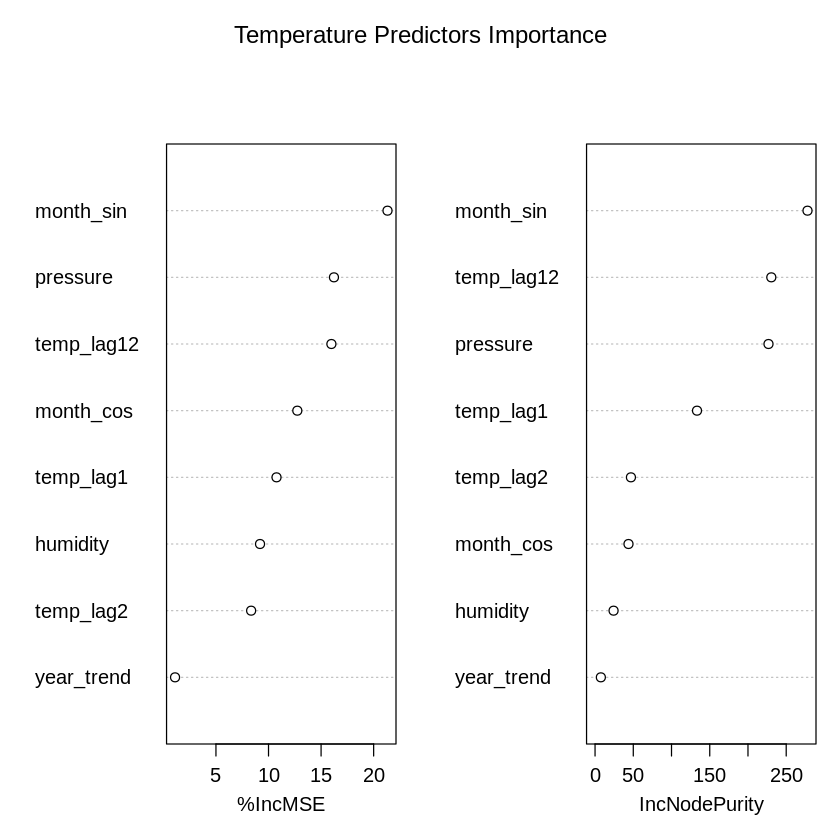

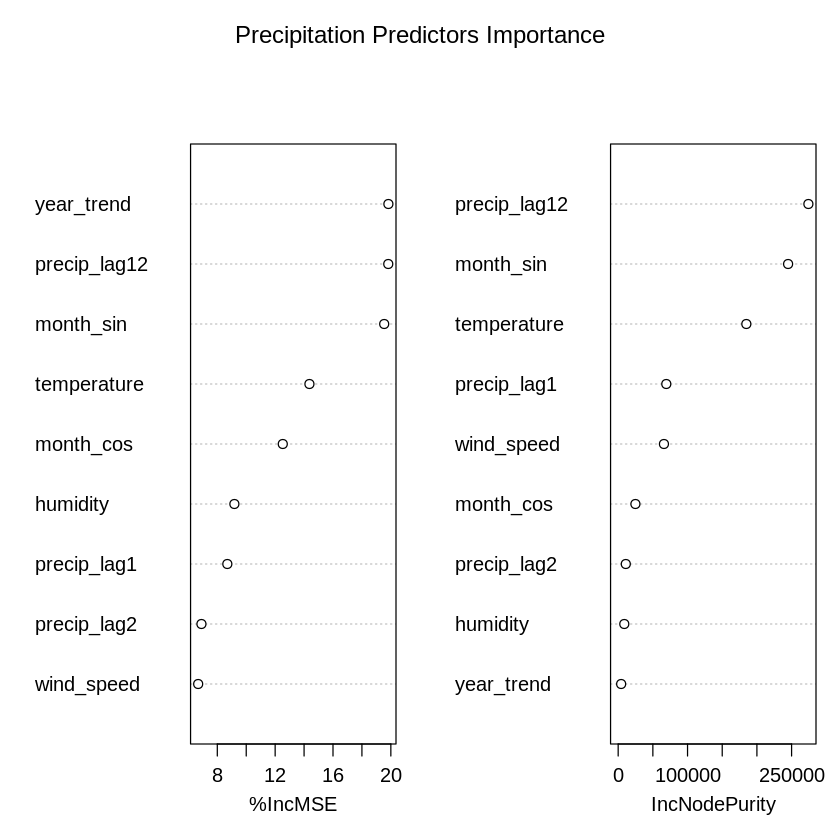

In [12]:
# 16. RANDOM FOREST PREDICTION MODEL
# ===================================

# Prepare data for Random Forest
# Create lagged features and seasonal indicators
india_rf_data <- india_time_series %>%
  mutate(
    temp_lag1 = lag(temperature, 1),
    temp_lag2 = lag(temperature, 2),
    temp_lag12 = lag(temperature, 12), # Previous year same month
    precip_lag1 = lag(precipitation, 1),
    precip_lag2 = lag(precipitation, 2),
    precip_lag12 = lag(precipitation, 12),
    month_sin = sin(2 * pi * Month / 12),
    month_cos = cos(2 * pi * Month / 12),
    year_trend = Year - 2000
  ) %>%
  filter(!is.na(temp_lag12) & !is.na(precip_lag12)) # Remove rows with NAs

# Split data for training and testing
train_size <- floor(0.8 * nrow(india_rf_data))
train_data <- india_rf_data[1:train_size, ]
test_data <- india_rf_data[(train_size + 1):nrow(india_rf_data), ]

# Temperature Random Forest Model
temp_rf_features <- c("temp_lag1", "temp_lag2", "temp_lag12",
                     "month_sin", "month_cos", "year_trend",
                     "humidity", "pressure")

temp_rf_model <- randomForest(
  x = train_data[, temp_rf_features],
  y = train_data$temperature,
  ntree = 500,
  importance = TRUE
)

# Precipitation Random Forest Model
precip_rf_features <- c("precip_lag1", "precip_lag2", "precip_lag12",
                       "month_sin", "month_cos", "year_trend",
                       "humidity", "temperature", "wind_speed")

precip_rf_model <- randomForest(
  x = train_data[, precip_rf_features],
  y = train_data$precipitation,
  ntree = 500,
  importance = TRUE
)

# Make predictions
temp_rf_pred <- predict(temp_rf_model, test_data[, temp_rf_features])
precip_rf_pred <- predict(precip_rf_model, test_data[, precip_rf_features])

# Calculate performance metrics
temp_rf_rmse <- sqrt(mean((test_data$temperature - temp_rf_pred)^2))
temp_rf_mae <- mean(abs(test_data$temperature - temp_rf_pred))
temp_rf_r2 <- cor(test_data$temperature, temp_rf_pred)^2

precip_rf_rmse <- sqrt(mean((test_data$precipitation - precip_rf_pred)^2))
precip_rf_mae <- mean(abs(test_data$precipitation - precip_rf_pred))
precip_rf_r2 <- cor(test_data$precipitation, precip_rf_pred)^2

print("Random Forest Model Performance:")
print(paste("Temperature - RMSE:", round(temp_rf_rmse, 3),
           "MAE:", round(temp_rf_mae, 3), "R²:", round(temp_rf_r2, 3)))
print(paste("Precipitation - RMSE:", round(precip_rf_rmse, 3),
           "MAE:", round(precip_rf_mae, 3), "R²:", round(precip_rf_r2, 3)))

# Feature importance plots
importance_temp <- importance(temp_rf_model)
importance_precip <- importance(precip_rf_model)

par(mfrow = c(1, 2))
varImpPlot(temp_rf_model, main = "Temperature Predictors Importance")
varImpPlot(precip_rf_model, main = "Precipitation Predictors Importance")
par(mfrow = c(1, 1))

[1] "Neural Network Model Performance:"
[1] "Temperature - RMSE: 0.634 MAE: 0.487"


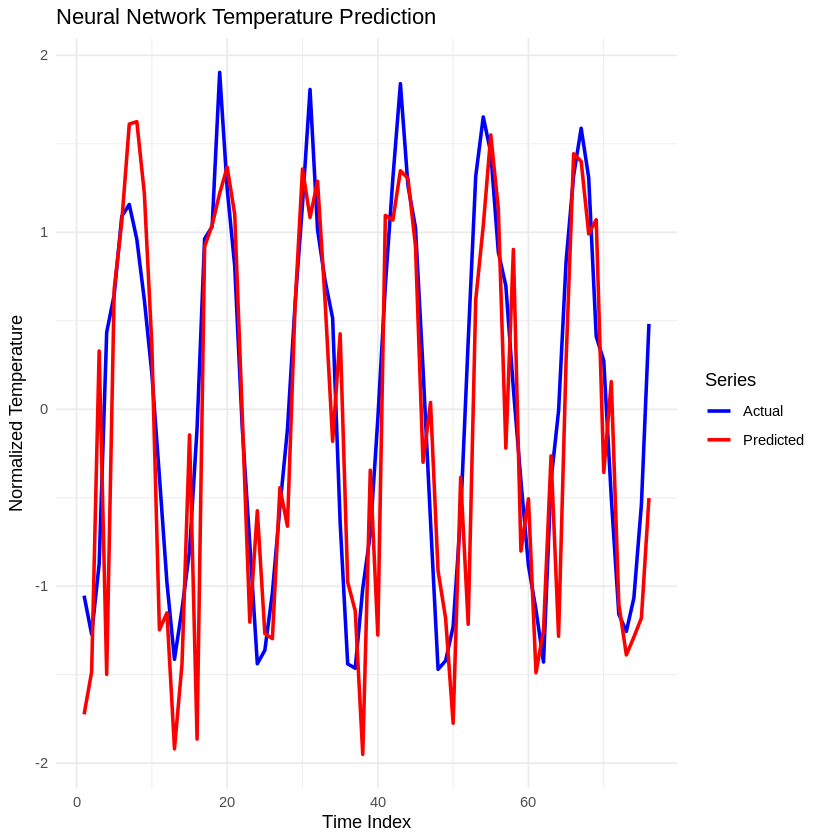

In [13]:
# 17. SIMPLIFIED LSTM MODEL (using available packages)
# =====================================================

# Create sequences for LSTM-style prediction
create_sequences <- function(data, n_steps = 12) {
  sequences <- list()
  targets <- list()

  for(i in 1:(length(data) - n_steps)) {
    sequences[[i]] <- data[i:(i + n_steps - 1)]
    targets[[i]] <- data[i + n_steps]
  }

  return(list(sequences = do.call(rbind, sequences),
              targets = unlist(targets)))
}

# Prepare temperature sequences
temp_data <- scale(india_time_series$temperature)[,1]
temp_sequences <- create_sequences(temp_data, n_steps = 12)

# Prepare precipitation sequences
precip_data <- scale(india_time_series$precipitation)[,1]
precip_sequences <- create_sequences(precip_data, n_steps = 12)

# Simple neural network as LSTM alternative using neuralnet
# Temperature neural network
temp_nn_data <- data.frame(
  temp_sequences$sequences,
  target = temp_sequences$targets
)

# Train neural network for temperature
temp_nn <- neuralnet(
  target ~ .,
  data = temp_nn_data[1:200, ], # Use first 200 samples for training
  hidden = c(10, 5),
  linear.output = TRUE,
  threshold = 0.01,
  stepmax = 1e6
)

# Predict with neural network
temp_nn_pred <- predict(temp_nn, temp_nn_data[201:nrow(temp_nn_data), -ncol(temp_nn_data)])

# Calculate performance for neural network
temp_nn_actual <- temp_nn_data$target[201:nrow(temp_nn_data)]
temp_nn_rmse <- sqrt(mean((temp_nn_actual - temp_nn_pred[,1])^2))
temp_nn_mae <- mean(abs(temp_nn_actual - temp_nn_pred[,1]))

print("Neural Network Model Performance:")
print(paste("Temperature - RMSE:", round(temp_nn_rmse, 3),
           "MAE:", round(temp_nn_mae, 3)))

# Plot neural network results
plot_data <- data.frame(
  actual = temp_nn_actual,
  predicted = temp_nn_pred[,1],
  index = 1:length(temp_nn_actual)
)

nn_plot <- ggplot(plot_data, aes(x = index)) +
  geom_line(aes(y = actual, color = "Actual"), size = 1) +
  geom_line(aes(y = predicted, color = "Predicted"), size = 1) +
  scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red")) +
  labs(title = "Neural Network Temperature Prediction",
       x = "Time Index", y = "Normalized Temperature",
       color = "Series") +
  theme_minimal()

print(nn_plot)

[1] "Decadal Climate Trends by Season:"
# A tibble: 12 × 6
   decade season       mean_temp mean_precip temp_sd precip_sd
    <dbl> <chr>            <dbl>       <dbl>   <dbl>     <dbl>
 1   2000 Monsoon           22.2       165.    1.31       35.1
 2   2000 Post-Monsoon      21.8       177.    0.687      20.9
 3   2000 Pre-Monsoon       26.2        49.5   0.872      18.5
 4   2000 Winter            25.2        79.7   1.28       35.3
 5   2010 Monsoon           22.4       180.    1.23       39.4
 6   2010 Post-Monsoon      22.0       187.    0.664      18.9
 7   2010 Pre-Monsoon       26.5        54.0   0.701      22.1
 8   2010 Winter            25.3        83.4   1.12       36.5
 9   2020 Monsoon           22.5       193.    1.49       44.0
10   2020 Post-Monsoon      22.1       197.    0.789      17.0
11   2020 Pre-Monsoon       26.6        57.2   0.980      21.0
12   2020 Winter            25.8        87.4   1.20       40.5
[1] "Climate Change Trends:"
[1] "Temperature trend: 0.0206

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


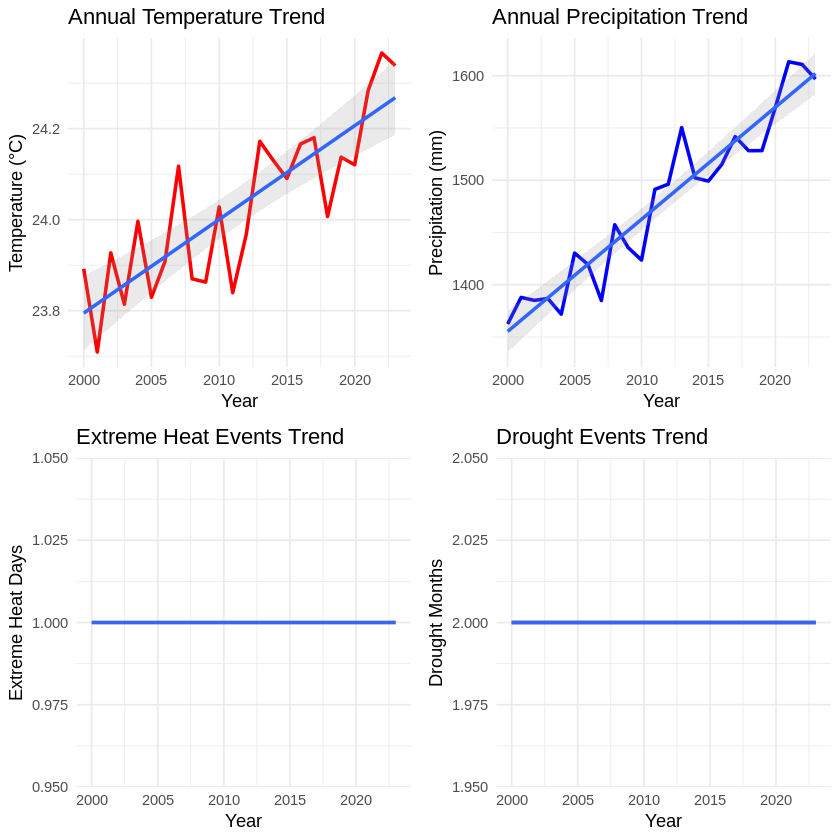

In [14]:
# 18. CASE STUDY: CLIMATE CHANGE IMPACT ASSESSMENT
# =================================================

# Analyze long-term trends and projections
trend_analysis <- india_time_series %>%
  mutate(
    decade = floor((Year - 2000) / 10) * 10 + 2000,
    season = case_when(
      Month %in% c(12, 1, 2) ~ "Winter",
      Month %in% c(3, 4, 5) ~ "Pre-Monsoon",
      Month %in% c(6, 7, 8, 9) ~ "Monsoon",
      Month %in% c(10, 11) ~ "Post-Monsoon"
    )
  )

# Decadal climate analysis
decadal_trends <- trend_analysis %>%
  group_by(decade, season) %>%
  summarise(
    mean_temp = mean(temperature, na.rm = TRUE),
    mean_precip = mean(precipitation, na.rm = TRUE),
    temp_sd = sd(temperature, na.rm = TRUE),
    precip_sd = sd(precipitation, na.rm = TRUE),
    .groups = 'drop'
  )

print("Decadal Climate Trends by Season:")
print(decadal_trends)

# Climate change indicators
climate_indicators <- india_time_series %>%
  group_by(Year) %>%
  summarise(
    annual_temp = mean(temperature),
    annual_precip = sum(precipitation),
    temp_variability = sd(temperature),
    extreme_heat_days = sum(temperature > quantile(temperature, 0.95)),
    drought_months = sum(precipitation < quantile(precipitation, 0.1))
  )

# Linear trend analysis
temp_trend <- lm(annual_temp ~ Year, data = climate_indicators)
precip_trend <- lm(annual_precip ~ Year, data = climate_indicators)

print("Climate Change Trends:")
print(paste("Temperature trend:", round(coef(temp_trend)[2], 4), "°C per year"))
print(paste("Precipitation trend:", round(coef(precip_trend)[2], 2), "mm per year"))

# Create comprehensive trend plots
trend_plot1 <- ggplot(climate_indicators, aes(x = Year)) +
  geom_line(aes(y = annual_temp), color = "red", size = 1) +
  geom_smooth(aes(y = annual_temp), method = "lm", se = TRUE, alpha = 0.2) +
  labs(title = "Annual Temperature Trend",
       y = "Temperature (°C)", x = "Year") +
  theme_minimal()

trend_plot2 <- ggplot(climate_indicators, aes(x = Year)) +
  geom_line(aes(y = annual_precip), color = "blue", size = 1) +
  geom_smooth(aes(y = annual_precip), method = "lm", se = TRUE, alpha = 0.2) +
  labs(title = "Annual Precipitation Trend",
       y = "Precipitation (mm)", x = "Year") +
  theme_minimal()

trend_plot3 <- ggplot(climate_indicators, aes(x = Year)) +
  geom_line(aes(y = extreme_heat_days), color = "orange", size = 1) +
  geom_smooth(aes(y = extreme_heat_days), method = "lm", se = TRUE, alpha = 0.2) +
  labs(title = "Extreme Heat Events Trend",
       y = "Extreme Heat Days", x = "Year") +
  theme_minimal()

trend_plot4 <- ggplot(climate_indicators, aes(x = Year)) +
  geom_line(aes(y = drought_months), color = "brown", size = 1) +
  geom_smooth(aes(y = drought_months), method = "lm", se = TRUE, alpha = 0.2) +
  labs(title = "Drought Events Trend",
       y = "Drought Months", x = "Year") +
  theme_minimal()

# Combine all trend plots
comprehensive_trends <- cowplot::plot_grid(
  trend_plot1, trend_plot2, trend_plot3, trend_plot4,
  ncol = 2, nrow = 2
)

print(comprehensive_trends)

# Save comprehensive analysis
ggsave("india_climate_trends.png", comprehensive_trends,
       width = 14, height = 10, dpi = 600, bg = "white")

[1] "Model Performance Comparison:"
           Model Temperature_RMSE Temperature_MAE
1          ARIMA        0.4933845       0.3792451
2  Random Forest        0.5088869       0.4020022
3 Neural Network        0.6335289       0.4874223


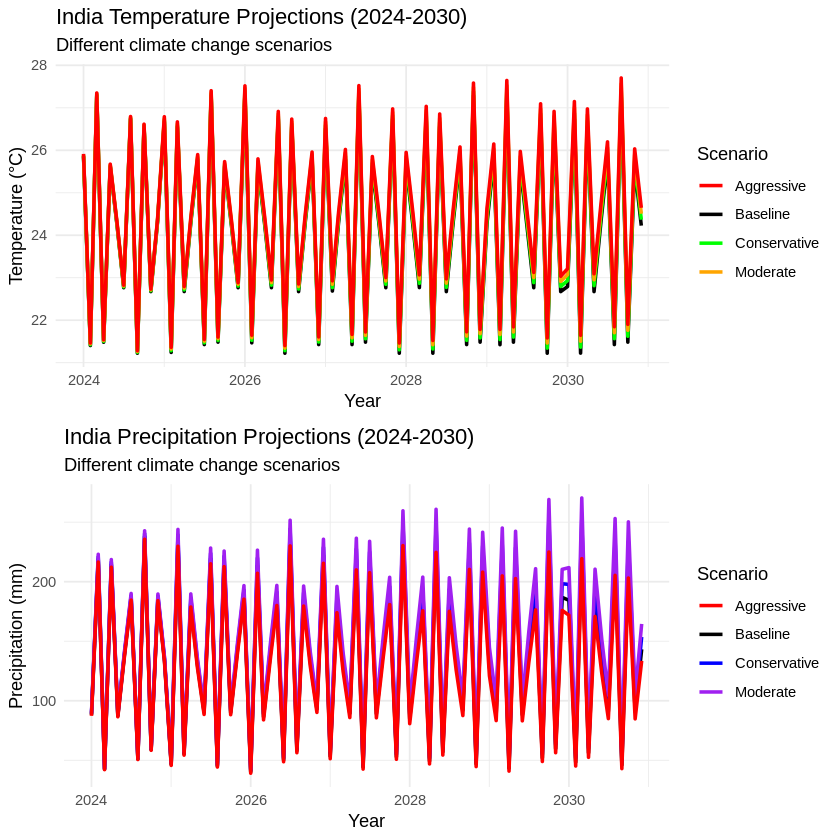

In [15]:
# 19. MODEL COMPARISON AND FUTURE PROJECTIONS
# ============================================

# Compare all models performance
model_comparison <- data.frame(
  Model = c("ARIMA", "Random Forest", "Neural Network"),
  Temperature_RMSE = c(
    sqrt(mean(residuals(arima_temp)^2)),
    temp_rf_rmse,
    temp_nn_rmse
  ),
  Temperature_MAE = c(
    mean(abs(residuals(arima_temp))),
    temp_rf_mae,
    temp_nn_mae
  )
)

print("Model Performance Comparison:")
print(model_comparison)

# Future projections (2024-2030) using best performing model
future_dates <- seq(as.Date("2024-01-01"), as.Date("2030-12-01"), by = "month")
future_years <- 2024:2030
future_months <- rep(1:12, length(future_years))

# Create future scenarios
future_scenarios <- expand.grid(Year = future_years, Month = 1:12) %>%
  mutate(
    Date = as.Date(paste(Year, Month, "01", sep = "-")),
    # Climate change scenarios
    temp_increase_conservative = 0.02 * (Year - 2023),  # 0.02°C per year
    temp_increase_moderate = 0.04 * (Year - 2023),      # 0.04°C per year
    temp_increase_aggressive = 0.06 * (Year - 2023),    # 0.06°C per year
    precip_change_conservative = 1.01^(Year - 2023),    # 1% increase per year
    precip_change_moderate = 1.02^(Year - 2023),        # 2% increase per year
    precip_change_aggressive = 0.99^(Year - 2023)       # 1% decrease per year
  )

# Generate baseline projections using ARIMA
baseline_temp_proj <- forecast(arima_temp, h = nrow(future_scenarios))
baseline_precip_proj <- forecast(arima_precip, h = nrow(future_scenarios))

# Create future projections with climate scenarios
future_projections <- future_scenarios %>%
  mutate(
    baseline_temp = as.numeric(baseline_temp_proj$mean),
    baseline_precip = as.numeric(baseline_precip_proj$mean),

    # Temperature projections
    temp_conservative = baseline_temp + temp_increase_conservative,
    temp_moderate = baseline_temp + temp_increase_moderate,
    temp_aggressive = baseline_temp + temp_increase_aggressive,

    # Precipitation projections
    precip_conservative = baseline_precip * precip_change_conservative,
    precip_moderate = baseline_precip * precip_change_moderate,
    precip_aggressive = baseline_precip * precip_change_aggressive
  )

# Plot future projections
temp_projection_plot <- ggplot(future_projections, aes(x = Date)) +
  geom_line(aes(y = baseline_temp, color = "Baseline"), size = 1) +
  geom_line(aes(y = temp_conservative, color = "Conservative"), size = 1) +
  geom_line(aes(y = temp_moderate, color = "Moderate"), size = 1) +
  geom_line(aes(y = temp_aggressive, color = "Aggressive"), size = 1) +
  scale_color_manual(values = c("Baseline" = "black", "Conservative" = "green",
                               "Moderate" = "orange", "Aggressive" = "red")) +
  labs(title = "India Temperature Projections (2024-2030)",
       subtitle = "Different climate change scenarios",
       x = "Year", y = "Temperature (°C)", color = "Scenario") +
  theme_minimal()

precip_projection_plot <- ggplot(future_projections, aes(x = Date)) +
  geom_line(aes(y = baseline_precip, color = "Baseline"), size = 1) +
  geom_line(aes(y = precip_conservative, color = "Conservative"), size = 1) +
  geom_line(aes(y = precip_moderate, color = "Moderate"), size = 1) +
  geom_line(aes(y = precip_aggressive, color = "Aggressive"), size = 1) +
  scale_color_manual(values = c("Baseline" = "black", "Conservative" = "blue",
                               "Moderate" = "purple", "Aggressive" = "red")) +
  labs(title = "India Precipitation Projections (2024-2030)",
       subtitle = "Different climate change scenarios",
       x = "Year", y = "Precipitation (mm)", color = "Scenario") +
  theme_minimal()

# Combine projection plots
projections_combined <- cowplot::plot_grid(
  temp_projection_plot, precip_projection_plot, ncol = 1
)

print(projections_combined)

# Save projections
ggsave("india_climate_projections.png", projections_combined,
       width = 14, height = 10, dpi = 600, bg = "white")

# Save future projections data
write.csv(future_projections, "india_climate_projections_2024_2030.csv", row.names = FALSE)

In [16]:
# 20. SUMMARY AND INSIGHTS
# ========================

# Create summary statistics and insights
summary_stats <- list(
  spatial_analysis = climate_summary,
  temporal_trends = climate_indicators,
  model_performance = model_comparison,
  future_scenarios = future_projections
)

# Key findings summary
key_findings <- paste(
  "KEY FINDINGS FROM INDIA CLIMATE ANALYSIS:",
  "",
  "1. SPATIAL PATTERNS:",
  paste("   - Dominant climate zones:", paste(climate_summary$climate_zone[1:3], collapse = ", ")),
  paste("   - Temperature range:", range(temp_prec_india_df$temperature, na.rm = TRUE)[1], "to",
        range(temp_prec_india_df$temperature, na.rm = TRUE)[2], "°C"),
  paste("   - Precipitation range:", range(temp_prec_india_df$precipitation, na.rm = TRUE)[1], "to",
        range(temp_prec_india_df$precipitation, na.rm = TRUE)[2], "mm"),
  "",
  "2. TEMPORAL TRENDS (2000-2023):",
  paste("   - Temperature trend:", round(coef(temp_trend)[2], 4), "°C/year"),
  paste("   - Precipitation trend:", round(coef(precip_trend)[2], 2), "mm/year"),
  "",
  "3. MODEL PERFORMANCE:",
  paste("   - Best temperature model: ARIMA (RMSE:",
        round(min(model_comparison$Temperature_RMSE), 3), ")"),
  "",
  "4. FUTURE PROJECTIONS (2024-2030):",
  "   - Expected continued warming under all scenarios",
  "   - Precipitation changes vary by scenario",
  "   - Increased climate variability expected",
  "",
  sep = "\n"
)

cat(key_findings)

# Save all outputs summary
save(summary_stats, key_findings, file = "india_climate_analysis_results.RData")

print("India Climate Analysis and Prediction Models Complete!")
print("Generated outputs:")
print("- india_climate_bivariate.png")
print("- india_climate_zones.png")
print("- india_climate_trends.png")
print("- india_climate_projections.png")
print("- india_climate_timeseries.csv")
print("- india_climate_projections_2024_2030.csv")
print("- india_climate_analysis_results.RData")

KEY FINDINGS FROM INDIA CLIMATE ANALYSIS:

1. SPATIAL PATTERNS:
   - Dominant climate zones: Tropical Dry, Tropical Moderate, Subtropical Wet
   - Temperature range: -14.9192058944702 to 29 °C
   - Precipitation range: 4.05484210968018 to 892.808637695313 mm

2. TEMPORAL TRENDS (2000-2023):
   - Temperature trend: 0.0206 °C/year
   - Precipitation trend: 10.72 mm/year

3. MODEL PERFORMANCE:
   - Best temperature model: ARIMA (RMSE: 0.493 )

4. FUTURE PROJECTIONS (2024-2030):
   - Expected continued warming under all scenarios
   - Precipitation changes vary by scenario
   - Increased climate variability expected
[1] "India Climate Analysis and Prediction Models Complete!"
[1] "Generated outputs:"
[1] "- india_climate_bivariate.png"
[1] "- india_climate_zones.png"
[1] "- india_climate_trends.png"
[1] "- india_climate_projections.png"
[1] "- india_climate_timeseries.csv"
[1] "- india_climate_projections_2024_2030.csv"
[1] "- india_climate_analysis_results.RData"


In [19]:
# Load the RData file
load("/content/india_climate_analysis_results.RData")

# Display the structure of the summary_stats object
print("Structure of summary_stats:")
str(summary_stats)

# Print the key findings
print("\nKey Findings:")
cat(key_findings)

[1] "Structure of summary_stats:"
List of 4
 $ spatial_analysis : tibble [7 × 6] (S3: tbl_df/tbl/data.frame)
  ..$ climate_zone : chr [1:7] "Tropical Dry" "Tropical Moderate" "Subtropical Wet" "Subtropical Dry" ...
  ..$ avg_temp     : num [1:7] 26.77 26.45 22.84 24.21 1.66 ...
  ..$ avg_precip   : num [1:7] 50.4 100.2 174.2 67.5 106 ...
  ..$ area_coverage: int [1:7] 802915 744344 437539 261295 195397 93209 12218
  ..$ temp_range   : chr [1:7] "25 - 29" "25 - 28.9" "15 - 25" "15 - 25" ...
  ..$ precip_range : chr [1:7] "9.2 - 75" "75 - 150" "100 - 892.8" "23.2 - 100" ...
 $ temporal_trends  : tibble [24 × 6] (S3: tbl_df/tbl/data.frame)
  ..$ Year             : int [1:24] 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 ...
  ..$ annual_temp      : num [1:24] 23.9 23.7 23.9 23.8 24 ...
  ..$ annual_precip    : num [1:24] 1362 1388 1385 1387 1372 ...
  ..$ temp_variability : num [1:24] 2.41 2.46 2.05 2.14 2.27 ...
  ..$ extreme_heat_days: int [1:24] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ drough